# Reproducible exploratory analysis: Mitigating multiplicity when mining data

Identifying meaningful patterns and relationships within noisy data is a fundamental component of neuroscience research; however, multiplicity — the practice of conducting multiple simultaneous comparisons - can result in spurious and misleading conclusions. In this unit, learners will understand how multiplicity occurs, its impacts, and strategies to address it.

<div class="alert alert-block alert-danger">
<b>Alert:</b> If you're running this on <b>Google Colab</b>, then uncomment and run the next two cells.
</div>

In [ ]:
# !git clone https://github.com/Mark-Kramer/METER-Units.git

In [ ]:
# import sys
# sys.path.insert(0,'/content/METER-Units')

## *1 - Rat brains, position, and profit: an introduction to exploratory analysis

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from matplotlib.colors import ListedColormap
# Load custom functions
from exploratory_functions import *

## EXTRA! EXTRA! RAT BRAINS CRACK THE STOCK MARKET CODE!

In a dazzling demonstration of rodent ingenuity—or perhaps sheer luck—[researchers have harnessed the firing neurons of rat motor cortices to predict movements in the U.S. stock market](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf). That’s right, folks! A team from Michigan and Georgia linked rat brain activity to Wall Street ticker tapes, proving that whiskers may rival Wall Street wits. By monitoring the firing rates of 94 neurons across three rats, these scientists uncovered correlations between neural activity and the daily closing prices of stocks on NASDAQ, the NYSE, and the American Stock Exchange. The Coca-Cola stock price, for instance, danced in sync with the neurons like Fred and Ginger at the Ziegfeld Follies.

But wait, there’s more! The researchers didn’t stop at finding patterns — they dove headfirst into the trading floor with a predictive model based on neural firing rates. Rats’ neural spikes gave the orders: buy, sell, or hold. And the results? An impressive 43% increase in a simulated portfolio value, turning an initial $\$$1,000 investment into a snappy $\$$1,435 over just 20 trading days. Forget the contrarian strategies of hedge fund honchos—our furry friends seem to have cracked the code.

And here’s the kicker, folks: this isn’t just about making a buck. The findings suggest a mysterious connection between rat neural activity and human economic behavior. The researchers propose a grand theory linking the creatures of Earth to the ebbs and flows of societal urges, tying their work to theories like Gaia’s interconnected organism hypothesis. So, the next time someone says, “it’s a rat race out there,” remember—they might just be running the show!

## That's quite a story ...
Using noisy data recorded from rodent brains, the authors found a relationship between neural activity and stock prices. At first glance, these results may seem consistent with well-established observations that neural activity encodes a rodent's location in its world [citation](https://www.nature.com/articles/514153a). However, you might also be (reasonably) skeptical. How could neural activity from a rat brain possibly predict the stock price of Coca-Cola?

In what follows, we'll investigate this question and see how multiplicity can produce spurious results. 



<div class="alert alert-block alert-success">

**Q:** When exploring data, the number of relationships between the things you observe increases quickly with the number of observed items. To get a sense for this, consider observations from `N` neurons (e.g., spiking activity) and `M` signals (e.g., stock prices). How many possible combinations of relationships exist between the neurons and signals?

**A:**  N*M

*Interpretation*: That number can get very big with modern data observations! How do you decide which of these comparisons are meaningful?

</div>

<div class="alert alert-block alert-success">

**Q:** In the article discused above ([Stock Market Behavior Predicted by Rat
Neurons](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf), Annals of Improbable Research), activity from 94 neurons was compared with activity from 4195 stocks. How many possible combinations of relationships exist between the neurons and stock signals?

**A:**  94*4195 = 381,745

*Interpretation*: That's a lot of relationships to examine! How do you decide which of these comparisons are meaningful?

</div>

## 1 - Visualization, the first step in exploration

Motivated by [previous](https://www.nature.com/articles/514153a) [studies](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf), you receive data from a collaborator interested in understanding the relationship between neural spiking in the rodent brain, rodent position, and stock prices on the NYSE. The data consist of the following information:

* `spikes`  - the action potentials (or "spikes") generated by 200 neurons,

* `signals` - the rodent position (one of the signals) and the price of 99 stocks.

Both the `spikes` and `signals` are recorded simultaneously, every 10 ms for 0.5 s, resulting in a total of 500 time points.

In [3]:
spikes, signals, t = load_data()

We're interested in understanding the relationship (if any) between `spikes` and `signals`.

Let's start by investigating the structure of the data.

In [4]:
print(spikes.shape)
print(signals.shape)

(500, 200)
(500, 100)


Both `spikes` and `signals` consist of 500 time points (the number of rows). We collect data from 200 neurons and 100 signals (the number of columns).

You might think of these variables as rectangles (or matrices), where each row indicates a time point, and each column indicates a neuron or signal:

![title](IMG_Exploratory/simple_boxes_neuron_and_signals.jpg)

Let's plot the data from one neuron in `spikes`:

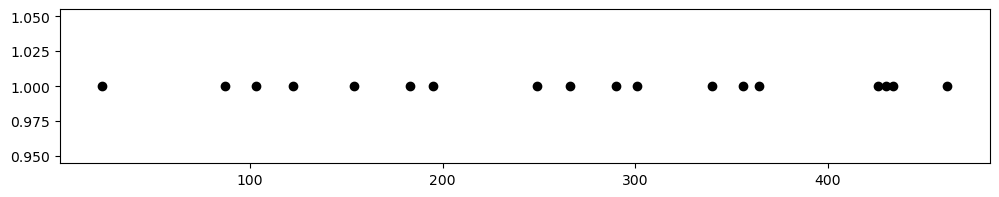

In [5]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 2))
plot_spike_train(t, spikes[:,0])  # Plot the first spike train.

<div class="alert alert-block alert-success">

**Q:** How do these data represent "spikes"?

**A:** In this signal, the value 1 represents a spike occurs at time 't'. The value 0 indicates that no spike occurs at time 't'. In the figure, we use a black circle to indicate the times of spikes.

</div>

Let's also plot the data from one signal in `signals`:

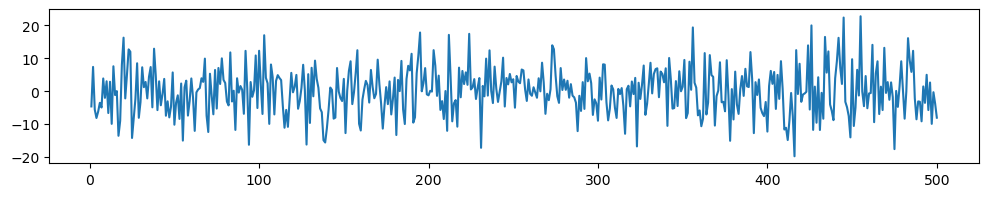

In [6]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 2))
plt.plot(t, signals[:,0]);

<div class="alert alert-block alert-success">

**Q:** What features do you notice in the signal?

**A:** It's "wiggly" and maybe there are rhythmic oscillations, but it's hard to tell. It's "noisy".

</div>

<div class="alert alert-block alert-success">

**Q:** Compare the plots of example spiking and an example signal. Are they related?

**A:** It's very difficult to tell what relationship - if any - exists between the signals.

*Interpretation*: Visual inspection is not especially useful in this example.


</div>

To more directly compare the `spikes` and `signals`, let's plot one atop the other:

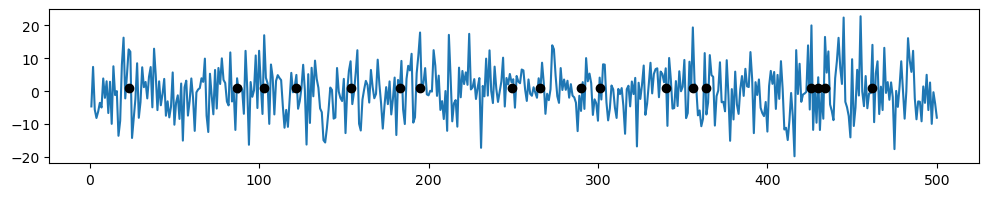

In [7]:
plt.figure(figsize=(12, 2))
plt.plot(t, signals[:,0]);        # Plot the first signal.
plot_spike_train(t, spikes[:,0])  # Plot the first spike train.

<div class="alert alert-block alert-success">

**Q:** Compare the spikes (black dots) and signal (blue trace) in the plot above. Are they related?

**A:** It's very difficult to tell what relationship - if any - exists between the signals.

*Interpretation*: Visual inspection is not especially useful in this example.

</div>

<div class="alert alert-block alert-success">

**Q:** We've used visual inspection to compare the spike train from one neuron (the first column of `spikes`) and one signal (the first column of `signals`). We didn't see an obvious relationship. However, there are many more relationships to compare. Repeat this analysis to compare each spike train (columns 1 to 200 of `spikes`) with each signal (columns 1 to 100 of `signals`). Do you observe any relationships?

**A:** Wait! That's 100*200 = 20,000 plots to visualize ...

</div>

<div class="alert alert-block alert-danger">
<b>Alert: We can't use visualization alone!</b>

</p>

- There are 200 neurons and 100 signals, resulting in 20,000 pairs to consider.

- We can't possibly visualize all of those.

- Instead, we need to perform statistical tests.
</div>

# 3- Profit! Rat brains for high-frequency trading in the NYSE

Let's now investigate the pairwise associations between the spiking of 200 neurons in the rat brain, the rat position, and 99 stock prices.

<div class="alert alert-block alert-success">

**Q:** We have 200 neurons and 100 signals. How many possible combinations of relationships exist between the neurons and signals?

**A:**  200*100 = 20,000

*Interpretation*: That's a large number! I wonder if we'll find something interesting in there ...

</div>

To compare the `spikes` and `signals`, we perform a statisitcal test of the association between each pair of data. There are many choices you could make to assess the associations and perform the statistical tests. We will not investigate those choice here. Instead, we will perform a sophisticated - yet standard - approach to assess the relationship between the `spikes` and `signals`; if you're interested in (many) more analysis details, check out [this link](https://mark-kramer.github.io/Case-Studies-Python/09.html).


Again, for our purposes, the details of the test are not important.

What is important is that **each test produces a p-value** and we interpret small p-values to indicate statistically significant associations (**link to Unit:"Putting the p-value in Context"**).

Let's compute those p-values now. This step is slow, because there are many p-values to compute!

In [8]:
p = compute_p_values(spikes, signals)

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


For each neuron-signal pair, we estimate the association with an associated p-value.

We now have 20,000 p-values to investigate.

To start, let's visualize those p-values.

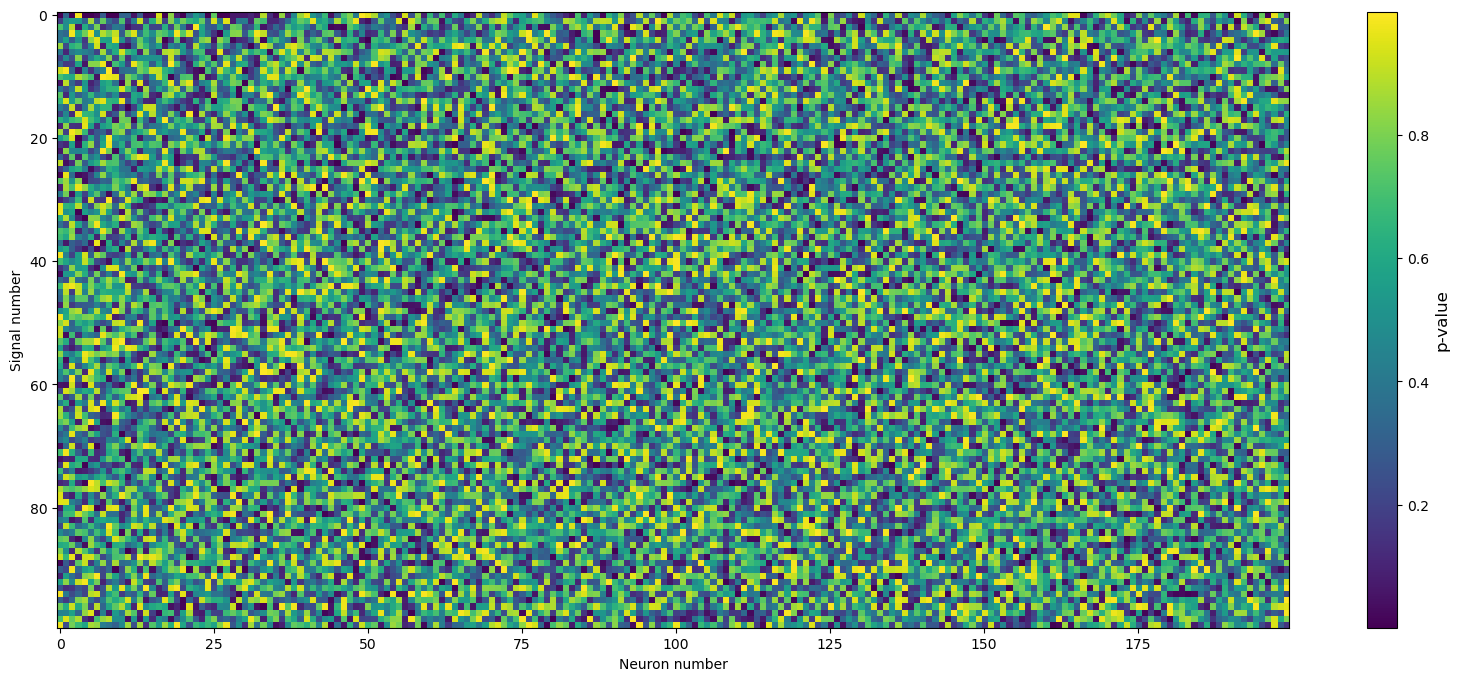

In [13]:
plt.figure(figsize=(20, 8))
plt.imshow(p); cbar = plt.colorbar(); cbar.set_label('p-value', fontsize=12)
plt.xlabel('Neuron number'); plt.ylabel('Signal number');

<div class="alert alert-block alert-success">

**Q:** What do you observe? Can you find the meaningful relationships between neurons and signals, if any? 

**A:** We're looking for small values (the darkest blue) in the image. There appear to be many dark blue pixels and it's very difficult to see the meaningful relationships. The image is noisy.

</div>

To isolate meaningful relationships, let's find all associations in which p<0.05, the standard threshold for signficance applied in practice (**link to Unit:"Putting the p-value in Context"**).

In [15]:
np.sum(p < 0.05)

1043

<div class="alert alert-block alert-success">

**Q:** Interpert this result. What do you conclude about the data?

**A:** Of the 20,000 possible associations between spikes and signals, we detect 1043 associations with p<0.05.

</div>

<div class="alert alert-block alert-info">

*Conclusion*:
- Rat brain neural activity is associated with stock prices and the rodent's position!
- Let's develop a new strategy for profitable high-frequency stock trading using rat brain neuron spiking.

</div>

<div class="alert alert-block alert-info">

*Reflection*:

- Hmm, there are a lot of significant relationships - this was so easy! Why doesn't everyone use rat brain activity to predict the stock market?
- Something must not be exactly correct…

</div>

<div class="alert alert-block alert-danger">
<b>Alert: Wait, this doesn't make sense!</b>

</p>

- How can the spike timing in a rat brain relate to stock market prices?

- We've conducted many (20,000 in fact) statistical tests and identified all associations with p<0.05 ... Is that the right choice?
</div>

<div class="alert alert-block alert-info">

*Moment of tension*:

- Hook the learner - "something isn't right and I want to know why."

</div>

# 4- Not so fast … finding meaningful relationships after you’ve tested everything.


In Mini 3, we assessed associations between 200 neurons and 100 signals.

This exploration led to many (20,000) statistical tests.

When we compute so many tests, we need to **correct for multiplicity**.

**Important fact**: When conducting multiple hypothesis tests, increased error rates occur because each test has a chance of incorrectly rejecting the null hypothesis (a false positive). This error, typically called the Type I error, is the probability of a single test falsely claiming a statistically significant effect.

As more tests are performed, the cumulative probability of committing at least one Type I error across all these tests increases, leading to an overall higher error rate for the set of tests than for any individual test. This phenomenon is often referred to as the ["multiple comparisons problem"](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) or "multiplicity."

**To mitigate multiplicity in our analysis**, we must account for increased error rates due to conducting multiple hypothesis tests on the same dataset.

<div class="alert alert-block alert-success">

**Q:** In our initial analysis, we found all p-values < 0.05. If we want to talk like a statistian, we'd say: "*We chose a Type I error rate ($\alpha$) of 0.05.*"

This means that each test has a probability of 0.05 of falsely claiming a statistically significant effect.

We performed 20,000 total tests. How many false statistically significant effects do we expect?

**A:** 20,000 * 0.05 = 1000

*Interpretation*: Because we conducted so many tests (20,000), and selected all associations with p<0.05, we expect 1000 false positives.

In Unit 3, we found 1043 associations with p<0.05. We conclude that most of these associatiosn are false positives!

</div>

<div class="alert alert-block alert-info">

*Extension / simulation to build intution (DRAFT):*

- Flip 5 coins. Are you likely to get all heads?
    - No. That's unlikely when you do it once.
- Now, ask 1000 people to repeat this 5 coin flip process. Do you think *someone* will get all heads?
    - Yes. By chance, someone might flip 5 coins and get all heads.
    - The goal of accounting for multiplcity is to control for these by chance occurrences.

</div>

**Many methods exist to correct for multiplicity.** In this unit, we'll investigate a couple of these methods. 

To start, let's apply one of the most popular procedures to correct for multiplicity: [**the Bonferroni correction**](https://en.wikipedia.org/wiki/Bonferroni_correction).

The Bonferroni correction reduces the Type I error rate by dividing the desired overall significance level ($\alpha$) by the number of tests performed (call it $m$). For example, if a trial is testing $m = 20$ hypotheses with a desired overall $\alpha = 0.05$, then the Bonferroni correction would test each individual hypothesis at $\alpha = 0.05/20 = 0.0025$.

The Bonferroni test is considered conservative because it adjusts the significance level $\alpha$ by dividing it by the number of comparisons. Doing so reduces the risk of Type I errors (false positives) but increases the likelihood of false negatives (i.e., incorrectly labeling a significant relationship as not significant).

<div class="alert alert-block alert-success">

**Q:** Compute the Bonferroni correction using our desired overall significance level ($\alpha=0.05$) and the number of tests performed.


**A:** 0.05 / 20000 = 0.0000025

*Interpretation*: Using the Bonferroni correction, we now declare associations as significant if p < 0.0000025.

</div>

Let's apply the Bonferroni correction to our matrix of p-values (`p`) and determine the number of significant associations, after correcting for multiplicity.

In [16]:
np.sum(p < 0.05/20000)

0

<div class="alert alert-block alert-success">

**Q:** Interpert this result. What do you conclude about the data?

**A:** Of the 20,000 possible associations between spikes and signals, we detect 0 associations with p<0.05 after applying the Bonferroni correction.

*Interpretation*: Rat brains not associated with stock prices or positions.

</div>

<div class="alert alert-block alert-danger">
<b>Alert: Wait, this doesn't make sense!</b>

</p>

- Much work (including [Noble Prize work](https://www.nature.com/articles/514153a)) has established a relationship between rat neuron spiking and rodent position.

- We've identified all associations with p<0.05 after Bonferroni correction ... Is that the right choice?

</div>

# 5- Rat brains either predict many things or no things?


We've applied two strategies to confront multiplicity in our analysis:

- Do nothing (Mini 3)
- Bonferroni correction (Mini 4)

The two strategies give completely different results. Either neurons in the rat brain spike with many associations to observed signals (Mini 3) or no associations (Mini 4). And, neither result makes sense when compared to the [existing](https://www.nature.com/articles/514153a) [literature](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf). **So, now what?**

Again, many strategies exist to correct for multiplicity. There's no single "right" approach.

- Our first approach (do nothing) is too lenient - we allow two many false positives. And, in doing so, we draw a ridiculous scientific conclusion: action potentials in the rat brain predict prices on the stock market.
  
- Our second approach (Bonferroni correction) is too strict - we allow too few false positives. And, in doing so, we find no evidence for a well-established scientific conclusion: action potentials in the rat brain encode the rodent's position.

Perhaps we can find an intermediate approach, that allows neither too many nor too few false positives ...

In what follows, you can explore alternatives to our choices above, and see how these choices impact your results.

## Choose your own adventure!

- False Discovery Rate or FDR (go to Mini 6)
- Split the data (go to Mini 7)



# 6- FDR: a less conservative approach to multiplicity.

You've chosen one approach to mitigate the impact of performing multiple statistical tests: calculate the False Discovery Rate (FDR).

To do so, we'll use the [Benjamini-Hochberg (BH) procedure](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x). The BH procedure is a statistical method to control the false discovery rate (FDR) in multiple hypothesis testing. It ranks the p-values from smallest to largest and compares each to a threshold that increases with rank, defined as $(r/m) \cdot q$, where $r$ is the rank of the p-value (i.e., the p-values position when ordered from smallest to largest), $m$ is the total number of tests, and $q$ is the desired FDR level, which is the expected proportion of false positives among all rejected hypotheses. For example, if $q = 0.05$, it means that, on average, no more than 5% of the rejected hypotheses are expected to be false positives. This allows for a controlled balance between identifying true effects and limiting false discoveries in multiple hypothesis testing.

Hypotheses corresponding to p-values below the threshold are rejected.

The BH procedure is less conservative than methods like Bonferroni correction, offering more power while maintaining control over the expected proportion of false positives.

The BH procedure is implemented in three steps:

1. **Assign each p-value a rank**, $r$, where the smallest p-value has rank $r=1$, the next smallest has rank $r=2$, and so on.

2. **Calculate the critical value** for each p-value using the formula:

$CriticalValue =(r/m) \cdot q$

where $m$ is the total number of tests, and $q$ is the desired overall significance level (typically 0.05 for 5% FDR).

3. **Compare each p-value to its corresponding critical value.** The largest rank, $r$, for which the p-value is less than or equal to the critical value is considered significant, and all p-values with ranks less than or equal to this $r$ are considered significant.

## To build some intuition for these steps, let's start with a simple example.

Consider an experiment in which you perform 5 hypothesis tests ($m=5$) and collect 5 p-values:

p-value: [0.1, 0.12, 0.001, 0.03, 0.045]

We conducted 5 tests, and decide to correct for multiplicity.

Let's use the p-values to perform each step of the Benjamini-Hochberg procedure.

<div class="alert alert-block alert-success">

**Q:** To start, order the p-values from smallest to largest.

**A:** [0.001, 0.015, 0.045, 0.1, 0.12]

</div>

<div class="alert alert-block alert-success">

**Q:** Then, perform Step 1. **Assign each p-value a rank**.

**A:**
p-value, Rank

0.001, $r=1$

0.015,  $r=2$

0.045, $r=3$

0.1,   $r=4$

0.12,  $r=5$

</div>

<div class="alert alert-block alert-success">

**Q:** Next, perform Step 2. **Calculate the critical value**.

**A:** The critical value for each p-value is $(r / m) \cdot q$. We choose $q=0.05$, which is the standard choice, and indicates that, on average, no more than 5% of the rejected hypotheses are expected to be false positives. 

The critical values for each rank are then:

Rank, Critical values

1, (1/5)*0.05 = 0.01

2, (2/5)*0.05 = 0.02

3, (3/5)*0.05 = 0.03

4, (4/5)*0.05 = 0.04

5, (5/5)*0.05 = 0.05


</div>

<div class="alert alert-block alert-success">

**Q:** Perform Step 3. **Compare each p-value to its corresponding critical value.**

**A:** Let's do this for each p-value, starting from the smallest p-value:

| p-value | Critical value | Is p-value less than critical value | Significant?|
|---------|----------------|-------------------------------------|-------------|
|0.001 | (1/5)*0.05 = 0.01 | Yes | significant
|0.015 | (2/5)*0.05 = 0.02 | Yes | significant
|0.045 | (3/5)*0.05 = 0.03 | No | not significant
|0.1   | (4/5)*0.05 = 0.04 | No | not significant
|0.12  | (5/5)*0.05 = 0.05 | No | not significant

Thus, p-values of 0.001 and 0.015 are considered significant under an FDR threshold of 5%. The p-values of 0.045, 0.1, 0.12 do not meet the significance threshold in this analysis.

</div>

<div class="alert alert-block alert-success">

**Q:** In this illustrative example, we found two p-values are considered significant using the FDR procedure. What would you find if you instead used a **Bonferroni correction**?

**A:** For the Bonferroni correction, we use the same threshold 0.05/5 = 0.01 for each comparison:

| p-value | Critical value | Is p-value less than critical value | Significant?|
|---------|----------------|-------------------------------------|-------------|
|0.001 | (1/5)*0.05 = 0.01 | Yes | significant
|0.03  | (1/5)*0.05 = 0.01 | No | not significant
|0.045 | (1/5)*0.05 = 0.01 | No | not significant
|0.1   | (1/5)*0.05 = 0.01 | No | not significant
|0.12  | (1/5)*0.05 = 0.01 | No | not significant

We now find that only one p-values (0.001) is considered significant under a Bonferroni correction.

</div>

Now, having built some intuition for computing the FDR using the Benjamini-Hochberg (BH) procedure, let's apply it to our data of interest.

It's the same idea, but instead of considering 5 p-values, we must consider the 20,000 p-values.

In [18]:
p_values_signficant_after_FDR = fdr(p)

The function `fdr` returns whether each p-value in `p` remains signficant after correcting for multiplicity using FDR. 

Let's display the p-values that remain significant after correcting for multiplicity using FDR:

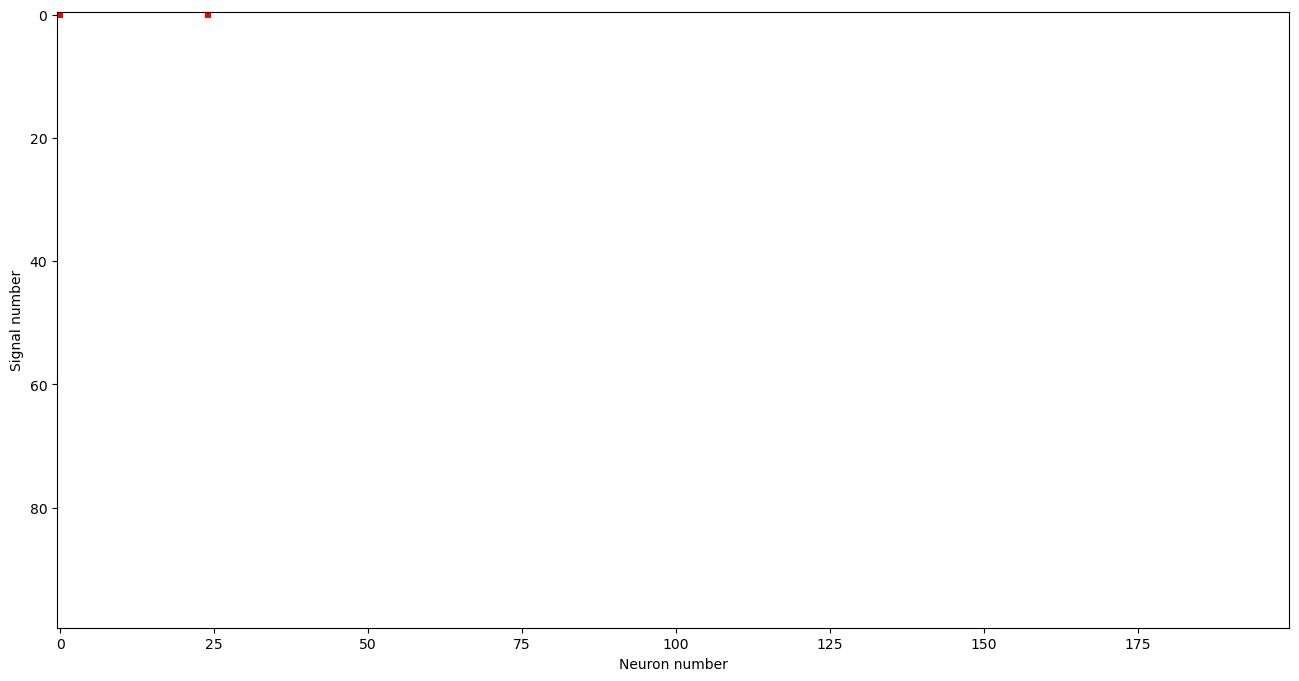

In [22]:
plt.figure(figsize=(20, 8))
cmap = ListedColormap(['white', 'red'])
plt.imshow(p_values_signficant_after_FDR, cmap=cmap)
plt.xlabel('Neuron number'); plt.ylabel('Signal number');

<div class="alert alert-block alert-success">

**Q:** Examine the figure above. Do you see any red dots, indicating significant relationships between neurons and signals after correcting for multiplicity using FDR?

**A:** There are two red dots, between:

"Signal 0" and "Neuron 0" -- i.e., the first signal and first neuron.

"Signal 0" and "Neuron 24" -- i.e., the first signal and 25th neuron.

</div>

<div class="alert alert-block alert-info">

*Interpretation*:

- We originally corrected for multiplicity using the Bonferroni correction. Following this strict correction, we found no evidence of significanet associations `spikes` and `signals`.

- After correcting for multiplicity using FDR, we now find two neurons in the rat brain are associated with the same signal ("Signal 0").

- We return to our collaborators and they confirm that "Signal 0" corresponds to the rodent's position.

</div>


<div class="alert alert-block alert-info">

*Relief*

- We've corrected for multiple comparisons using FDR and find a sensible result.

- The results are consistent with the existing theory that neuron's in the brain encode rodent position.
- We find no evidence that neurons in the rodent brain predict stock market prices.
- Using a less strict correction (FDR instead of Bonferroni) we identify significant associations in the data.

</div>

## 7- Split your data to test your conclusions.

(Pending)

(Use first half of data, in time)

In [ ]:
T = np.shape(spikes)[0];
p_split = compute_p_values(spikes[:,0:int(T/2)-1], signals[:,0:int(T/2)-1])

(Find candidate significant associations)

In [ ]:
candidate_significant_pairs = (p_split<0.05)
print(sum(candidate_significant_pairs.flatten()))
[i_signals,i_spikes] = np.where(candidate_significant_pairs)

(Test these predicted associations in the second half of data)

In [ ]:
p_test = np.zeros(np.shape(i_signals))
for index, element in enumerate(i_signals):
    X = signals[int(T/2):, i_signals[index]]       # Predictor variable
    y = spikes[int(T/2):, i_spikes[index]]        # Response variable
    X = sm.add_constant(X)  # Adding a constant column for the intercept
    glm_model = sm.GLM(y, X, family=sm.families.Poisson())
    glm_results = glm_model.fit()
    p_test[index] = glm_results.pvalues[1]

(Identify significant associations)

In [ ]:
i0 = np.where(p_test<0.05/np.size(i_signals))
print('Signal', i_signals[i0], ', Spike', i_spikes[i0])